In [128]:
# 모듈 임포트하기
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [129]:
# 딥러닝 모델을 설계할 때 활용하는 장비 확인하기
if torch.cuda.is_available() :
    DEVICE = torch.device('cuda')
else :
    DEVICE = torch.device('cpu')
print(f"Using PyTorch version : {torch.__version__}, Device : {DEVICE}")
BATCH_SIZE = 32
EPOCHS = 10

Using PyTorch version : 1.8.1, Device : cpu


In [130]:
# 개미와 벌을 분류하기 위해 데이터 불러오기 (train, test set 분리)
data_transfoms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224), # 이미지를 224 사이즈로 변경하는데 원래 이미지에서 224개의 픽셀을 랜덤을 랜덤으로 선택
        transforms.RandomHorizontalFlip(), # 이미지를 50% 확률로 좌우 반전
        transforms.ToTensor(), # 0~1 사이 값으로 정규화, 모델의 input으로 사용될 수 있도록 Tensor 형태로 변환
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    ]),
    'val' : transforms.Compose([
        transforms.CenterCrop(224),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    ]),
}

image_datasets = {x:datasets.ImageFolder(f"../data/hymenoptera_data/{x}", data_transfoms[x])
                  for x in ['train','val']}
data_loaders = {x:torch.utils.data.DataLoader(
    image_datasets[x], batch_size=BATCH_SIZE, num_workers=0, # multi-processing 관련 parameter
    shuffle=True) for x in ['train','val']}

In [131]:
# 데이터 확인하기 (1)
for (X_train, y_train) in data_loaders['train'] :
    print(f"X_train : {X_train.size()}, type : {X_train.type()}")
    print(f"y_train : {y_train.size()}, type : {y_train.type()}")
    break
for (X_val, y_val) in data_loaders['val'] :
    print(f"X_val : {X_val.size()}, type : {X_val.type()}")
    print(f"y_val : {y_val.size()}, type : {y_val.type()}")
    break

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
train_class_names = image_datasets['train'].classes
val_class_names = image_datasets['val'].classes
print(f"dataset_sizes : {dataset_sizes}")
print(f"train_class_names : {train_class_names}")
print(f"val_class_names : {val_class_names}")

X_train : torch.Size([32, 3, 224, 224]), type : torch.FloatTensor
y_train : torch.Size([32]), type : torch.LongTensor
X_val : torch.Size([32, 3, 256, 256]), type : torch.FloatTensor
y_val : torch.Size([32]), type : torch.LongTensor
dataset_sizes : {'train': 244, 'val': 153}
train_class_names : ['ants', 'bees']
val_class_names : ['ants', 'bees']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

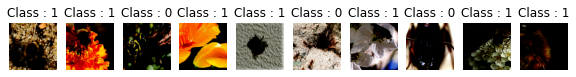

In [132]:
# 데이터 확인하기 (2)
pltsize = 1
plt.figure(figsize=(10*pltsize, pltsize))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i],(1,2,0)))
    plt.title(f'Class : {str(y_train[i].item())}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

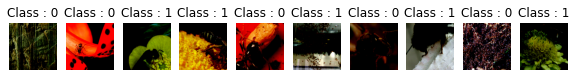

In [133]:
pltsize = 1
plt.figure(figsize=(10*pltsize, pltsize))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_val[i],(1,2,0)))
    plt.title(f'Class : {str(y_val[i].item())}')


In [134]:
# 불러온 특정 모델에 대해 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model, train_loader, optimizer, log_interval, epoch) :
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0 :
            print(f"Train Epoch : {epoch} [{batch_idx*len(image)}/"
                  f"{len(train_loader.dataset)}({100.*batch_idx/len(train_loader):.0f}%)]"
                  f"\tTrain Loss : {loss.item()}")

In [135]:
# 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad() :
        for image, label in test_loader :
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)

            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100.*correct/len(test_loader.dataset)
    return test_loss, test_accuracy

In [136]:
# 파이토치 내에서 제공하는 미리 학습되지 않은 ResNet18 모델을 불러온 후 Output의 크기 설정
import torchvision.models as models
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,2)
model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [137]:
# Optimizer, Objective function 설정
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [138]:
# 미리 학습되지 않은 ResNet18 학습을 실행하고 Train, Test Loss와 Test Acc 확인
for Epoch in range(1, EPOCHS+1):
    train(model, data_loaders['train'], optimizer, log_interval=5, epoch=Epoch)
    test_loss, test_accuracy = evaluate(model, data_loaders['val'])
    print(f"\n[EPOCH:{Epoch}] \tTest Loss : {test_loss:.4f} \tTest Accuracy : {test_accuracy:.2f}\n")

Train Epoch : 1 [0/244(0%)]	Train Loss : 0.6968439221382141
Train Epoch : 1 [160/244(62%)]	Train Loss : 0.6519690155982971

[EPOCH:1] 	Test Loss : 0.0234 	Test Accuracy : 49.02

Train Epoch : 2 [0/244(0%)]	Train Loss : 0.6322029829025269
Train Epoch : 2 [160/244(62%)]	Train Loss : 0.6189219951629639

[EPOCH:2] 	Test Loss : 0.0269 	Test Accuracy : 50.33

Train Epoch : 3 [0/244(0%)]	Train Loss : 0.5787372589111328
Train Epoch : 3 [160/244(62%)]	Train Loss : 0.5640602707862854

[EPOCH:3] 	Test Loss : 0.0249 	Test Accuracy : 55.56

Train Epoch : 4 [0/244(0%)]	Train Loss : 0.5459006428718567
Train Epoch : 4 [160/244(62%)]	Train Loss : 0.49876323342323303

[EPOCH:4] 	Test Loss : 0.0343 	Test Accuracy : 46.41

Train Epoch : 5 [0/244(0%)]	Train Loss : 0.501318633556366
Train Epoch : 5 [160/244(62%)]	Train Loss : 0.7029716372489929

[EPOCH:5] 	Test Loss : 0.0248 	Test Accuracy : 59.48

Train Epoch : 6 [0/244(0%)]	Train Loss : 0.4920921325683594
Train Epoch : 6 [160/244(62%)]	Train Loss : 0.5902

In [139]:
# ImageNet으로 미리 학습된 ResNet18 모델을 불러온 후 Fine tunning
model = models.resnet18(pretrained = True)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
for Epoch in range(1, EPOCHS + 1):
    train(model, data_loaders["train"], optimizer, log_interval = 5, epoch=Epoch)
    valid_loss, valid_accuracy = evaluate(model, data_loaders["val"])
    print(f"\n[EPOCH: {Epoch}], \tTest Loss: {valid_loss:.4f}, \tTest Accuracy: {valid_accuracy:.2f}\n")

Train Epoch : 1 [0/244(0%)]	Train Loss : 0.6730223894119263
Train Epoch : 1 [160/244(62%)]	Train Loss : 0.686159610748291

[EPOCH: 1], 	Test Loss: 0.0219, 	Test Accuracy: 53.59

Train Epoch : 2 [0/244(0%)]	Train Loss : 0.6088535189628601
Train Epoch : 2 [160/244(62%)]	Train Loss : 0.6290319561958313

[EPOCH: 2], 	Test Loss: 0.0215, 	Test Accuracy: 54.25

Train Epoch : 3 [0/244(0%)]	Train Loss : 0.6993979215621948
Train Epoch : 3 [160/244(62%)]	Train Loss : 0.636438250541687

[EPOCH: 3], 	Test Loss: 0.0208, 	Test Accuracy: 62.75

Train Epoch : 4 [0/244(0%)]	Train Loss : 0.5888020396232605
Train Epoch : 4 [160/244(62%)]	Train Loss : 0.6285589337348938

[EPOCH: 4], 	Test Loss: 0.0204, 	Test Accuracy: 62.75

Train Epoch : 5 [0/244(0%)]	Train Loss : 0.6790657639503479
Train Epoch : 5 [160/244(62%)]	Train Loss : 0.544119656085968

[EPOCH: 5], 	Test Loss: 0.0197, 	Test Accuracy: 67.97

Train Epoch : 6 [0/244(0%)]	Train Loss : 0.5875555276870728
Train Epoch : 6 [160/244(62%)]	Train Loss : 0.54